In [ ]:
#@title GitHub Token Ekle

import ipywidgets as widgets
from IPython.display import display
import os

def github_token_button_clicked(b):
    os.environ["GITHUB_TOKEN"] = "YOUR_GITHUB_TOKEN_HERE"
    print("GitHub Token ortam değişkenine eklendi!")

button1 = widgets.Button(
    description="GitHub Token Ekle",
    button_style='',
    tooltip='GitHub Token Ortam Değişkenine Ekle'
)
button1.on_click(github_token_button_clicked)
display(button1)

In [ ]:
#@title GitHub Token Ekle

import ipywidgets as widgets
import os
import datetime
from google.colab import drive
from IPython.display import display

def sync_drive_github(b):
    # Google Drive'ı bağla
    drive.mount('/content/drive', force_remount=True)

    # Git kullanıcı bilgilerini ayarla
    os.system('git config --global user.email "doganzub@gmail.com" > /dev/null 2>&1')
    os.system('git config --global user.name "doganzub" > /dev/null 2>&1')

    # GitHub Token kontrolü
    GITHUB_TOKEN = os.environ.get("GITHUB_TOKEN")
    if not GITHUB_TOKEN:
        print("❌ HATA: GitHub Token bulunamadı! Lütfen önce Buton 1 ile ayarlayın.")
        return

    # GitHub repo bağlantısı
    GITHUB_REPO = f"https://{GITHUB_TOKEN}@github.com/doganzub/ml.git"

    # Çalıştırılan notebook'un yolu ve adı (manuel düzenleyin)
    notebook_path = "/content/drive/MyDrive/Colab Notebooks/"
    running_notebook = "3_k_menas.ipynb"

    # Repo yoksa klonla
    if not os.path.exists("/content/ml"):
        os.system(f"cd /content && git clone {GITHUB_REPO}")

    # Git dizinine geç
    os.chdir("/content/ml")

    # Branch listesini al
    os.system("git fetch --all")
    existing_branches = os.popen("git branch -r").read()

    filename_parts = running_notebook.split("_")
    if not filename_parts[0].isdigit():
        print(f"🚫 {running_notebook} dosyasının başında rakam yok, işlem iptal edildi!")
    else:
        ders_no = filename_parts[0]
        branch_name = f"ders{ders_no}"

        if f"origin/{branch_name}" not in existing_branches:
            print(f"🚫 {branch_name} branch'i GitHub'da bulunamadı, işlem iptal edildi!")
        else:
            os.system(f"git checkout {branch_name}")
            os.system(f'cp "{notebook_path}{running_notebook}" "/content/ml/"')
            commit_message = f"{running_notebook} güncellendi - {datetime.datetime.now().strftime('%Y-%m-%d %H:%M')}"
            os.system("git add .")
            status = os.popen("git status --porcelain").read()

            if status.strip():
                os.system(f'git commit -m "{commit_message}"')
                os.system(f"git push origin {branch_name}")
                print(f"✅ {running_notebook} {branch_name} branch'ine yüklendi!")
            else:
                print(f"⚡ {running_notebook} için değişiklik yok, commit atlanıyor!")
            os.system(f'cp -f "/content/ml/{running_notebook}" "{notebook_path}"')

    print("🎯 GitHub ve Google Drive senkronize edildi!")

# Buton 2: Drive & GitHub Senkronizasyonu
button2 = widgets.Button(
    description="Drive & GitHub Senkronizasyonu",
    button_style='',
    tooltip='Google Drive ve GitHub arasında senkronizasyon yap'
)
button2.on_click(sync_drive_github)
display(button2)

# K-Means Kümeleme – Iris Veri Seti

Bu doküman, **Iris** veri setini kullanarak K-Means algoritması ile kümeleme örneğini gösterir. Hem teori hem kod bir arada sunulmuştur. Aşağıdaki bölümlerden geçeceğiz:

1. **Gerekli Kütüphaneler**  
2. **Veri Setinin Yüklenmesi ve İncelenmesi**  
3. **Korelasyon Analizi**  
4. **Verilerin Görselleştirilmesi**  
5. **K-Means Kümeleme Algoritmasının Uygulanması**  
6. **Kümeleme Sonuçlarının Görselleştirilmesi**  
7. **Kümeleme Kalitesinin Değerlendirilmesi (WSS, Silhouette)**  
8. **En İyi Küme Sayısının Belirlenmesi (Elbow, Silhouette)**

## Neden Önemli?
Kümeleme analizi, **gözetimsiz öğrenme** (unsupervised learning) stratejilerinden biridir. K-Means ise en popüler kümeleme algoritmalarından biridir ve veri içinde benzer örnekleri gruplara ayırma konusunda sıklıkla kullanılır.

Bu örnek üzerinden, veri incelemesinden başlayarak kümeleme sonuçlarına ve optimal küme sayısı seçim yöntemlerine kadar adım adım öğreneceğiz.

## 1️⃣ Gerekli Kütüphaneler

In [1]:
#Gerekli Kütüphaneler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets              # sklearn içinde hazır veri setleri bulunur
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# Uyarıları kapatmak için
import warnings
warnings.filterwarnings('ignore')

# Grafiklerin boyutu ve stili
sns.set(rc={'figure.figsize':(8,5)})


## 2️⃣ Veri Setinin Yüklenmesi ve İncelenmesi

Bu bölümde, Python'un **scikit-learn (sklearn)** kütüphanesi içinde hazır olarak bulunan **Iris Veri Setini** kullanacağız. Veri setini yükleyip pandas DataFrame formatına dönüştürecek, ardından yapısını inceleyeceğiz.

### 🌸 Iris Veri Seti Nedir?

Iris veri seti, **Makine Öğrenmesinde en sık kullanılan klasik veri setlerinden biridir**. Bu veri setinde üç farklı çiçek türüne (class) ait ölçümler bulunur:
- **Setosa**
- **Versicolor**
- **Virginica**

Her çiçek türünden **50 gözlem** olmak üzere toplam **150 gözlem** içerir.
Her gözlem için 4 farklı özellik ölçülmüştür:
- **Sepal Length (canakU)**: Çanak yaprağının uzunluğu
- **Sepal Width (canakG)**: Çanak yaprağının genişliği
- **Petal Length (tacU)**: Taç yaprağının uzunluğu
- **Petal Width (tacG)**: Taç yaprağının genişliği

Ayrıca her gözlem için çiçek türünü belirten bir **hedef değişken (tur)** bulunur. Bu değişken veri setinde sayısal (0, 1, 2) olarak gelir:
- `0 → setosa`
- `1 → versicolor`
- `2 → virginica`

### 🔍 Bu adımda neler yapacağız?
- Iris veri setini sklearn kütüphanesinden yükleyeceğiz.
- Özellikler (`X`) ve hedef değişkeni (`y`) ayıracağız.
- Özellikleri pandas DataFrame'e dönüştüreceğiz.
- Hedef değişkeni sayısal (0,1,2) yerine kategorik isimlere dönüştüreceğiz.
- İlk 5 satırı inceleyeceğiz.

Bu işlem, **veri setini tanımak ve analizlere başlamadan önce veri yapısını anlamak için önemli bir adımdır**.


In [4]:
# 🌸 1. Iris veri setini sklearn'den yüklüyoruz
iris = datasets.load_iris()  # Iris veri setini yükler

# 🟢 2. Özellikleri (bağımsız değişkenler) ve hedef değişkeni (bağımlı değişken) ayrı ayrı alıyoruz
X = iris.data         # Çiçek yapraklarına ait uzunluk ve genişlik bilgileri (4 özellik)
y = iris.target       # Çiçek tür bilgisi (0,1,2)

# 🟢 3. Özellikleri pandas DataFrame formatına dönüştürüyoruz
df = pd.DataFrame(X, columns=["canakU", "canakG", "tacU", "tacG"])
# canakU: Çanak uzunluğu, canakG: Çanak genişliği
# tacU: Taç uzunluğu, tacG: Taç genişliği

# 🔵 4. Tür bilgisini DataFrame'e ekliyoruz (0,1,2 değerleri)
df["tur"] = y

# 🔵 5. Sayısal tür bilgisini, çiçek isimleri ile değiştiriyoruz
df["tur"] = df["tur"].replace([0, 1, 2], list(iris.target_names))
# 0 → setosa, 1 → versicolor, 2 → virginica

# 🔵 6. Tür sütununu 'category' veri tipine dönüştürüyoruz
df["tur"] = df["tur"].astype("category")

# 🟢 7. İlk 5 satırı görüntülüyoruz
df.head()  # Veri setinin yapısını hızlıca görmek için kullanılır


,canakU,canakG,tacU,tacG,tur
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## 2️⃣ Korelasyon Analizi ve Isı Haritası

---

### Neden Korelasyon Analizi Yapılır?

Veri setinde birden fazla sayısal değişken bulunduğunda, bu değişkenler arasında nasıl bir ilişki olduğunu bilmek önemlidir.  
**Korelasyon Analizi**, iki sayısal değişken arasındaki ilişkinin yönünü (**pozitif/negatif**) ve gücünü gösteren bir yöntemdir.

**Korelasyon Katsayısı**:
- **+1** → İki değişken arasında **pozitif ve güçlü bir ilişki** vardır.
- **0** → İki değişken arasında **herhangi bir ilişki yoktur**.
- **-1** → İki değişken arasında **negatif ve güçlü bir ilişki** vardır.

---

### Bu bölümde ne yapıyoruz?

🔸 **NumPy** kütüphanesinin `corrcoef()` fonksiyonu ile Iris veri setinde bulunan sayısal değişkenlerin **korelasyon katsayılarını** hesaplıyoruz.

🔸 Hesapladığımız korelasyon katsayılarını **matris** formatında görselleştiriyoruz.

🔸 **Seaborn** kütüphanesinin **heatmap (ısı haritası)** fonksiyonu ile bu ilişkiyi daha anlaşılır şekilde sunuyoruz.  
Isı haritasındaki renkler, korelasyon değerinin büyüklüğünü kolayca görmemizi sağlar.

---

### Teknik Bilgi

**np.corrcoef() fonksiyonu:**
- NumPy kütüphanesinde yer alır.
- Birden fazla değişken arasındaki korelasyon katsayısını hesaplar.
- Parametre: `rowvar=False` → satırlar gözlemleri, sütunlar değişkenleri temsil eder.

**sns.heatmap() fonksiyonu:**
- Seaborn kütüphanesinde yer alır.
- Korelasyon matrisini renkler ile görselleştirir.
- Parametreler:
  - `annot=True` → Hücreler içine korelasyon katsayısı yazılır.
  - `square=True` → Hücreler kare şeklinde olur.
  - `cmap=flare` → Renk skalası (istenilen renk paleti seçilebilir).

---

### Neden Önemli?

Korelasyon analizi ile:

✅ Değişkenler arasında **doğrudan veya dolaylı ilişki olup olmadığını** tespit ederiz.  
✅ **Kümeleme, regresyon, sınıflandırma gibi modeller** kurmadan önce değişkenler arasındaki ilişkiyi anlama imkânı sağlar.  
✅ Gereksiz veya çok benzer değişkenleri belirleyerek **özellik seçiminde** faydalı olur.

---


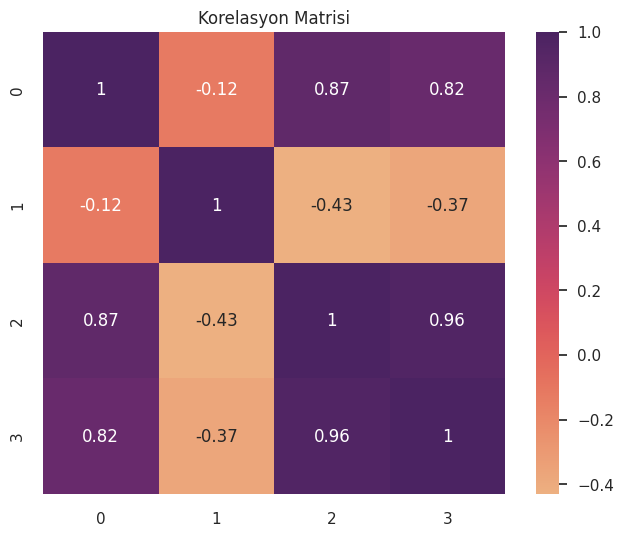

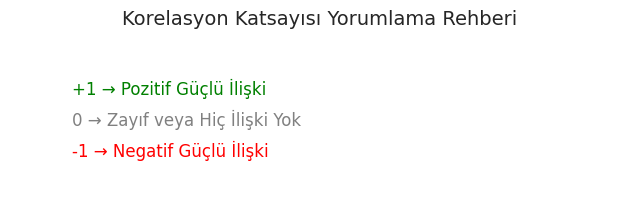

In [9]:
# 🔸 NumPy ile korelasyon matrisi hesaplama
my_cors = np.corrcoef(X, rowvar=False).round(2)

# 🔸 Korelasyon Matrisini Isı Haritası ile Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(
    my_cors,
    annot=True,  # Hücreler üzerinde korelasyon katsayısını göster
    square=True,  # Kare hücreler kullan
    cmap=sns.color_palette("flare", as_cmap=True)  # Renk paleti
)
plt.title("Korelasyon Matrisi")
plt.show()

# 🔥 Ekstra: Korelasyon Katsayısı Yorumlama Rehberi
plt.figure(figsize=(8, 2))
plt.text(0.1, 0.6, "+1 → Pozitif Güçlü İlişki", fontsize=12, color="green")
plt.text(0.1, 0.4, "0 → Zayıf veya Hiç İlişki Yok", fontsize=12, color="gray")
plt.text(0.1, 0.2, "-1 → Negatif Güçlü İlişki", fontsize=12, color="red")
plt.axis('off')
plt.title("Korelasyon Katsayısı Yorumlama Rehberi", fontsize=14)
plt.show()


## 4️⃣ Verilerin Görselleştirilmesi

Korelasyonu yüksek veya düşük olan çiftleri scatterplot ile inceleyebiliriz.
Burada *canakU - canakG* ve *tacU - tacG* çiftlerini `hue="tur"` ekleyerek türlere göre renklendiriyoruz.


In [ ]:
# canakU, canakG
sns.scatterplot(x="canakU", y="canakG", hue="tur", data=df, palette="rainbow")
plt.title("Sepal Uzunluk vs Genişlik")
plt.show()

# tacU, tacG
sns.scatterplot(x="tacU", y="tacG", hue="tur", data=df, palette="rainbow")
plt.title("Petal Uzunluk vs Genişlik")
plt.show()

## 5️⃣ K-Means Kümeleme Algoritmasının Uygulanması

**K-Means** algoritmasının adımları:
1. Rastgele veya akıllı bir yöntem (k-means++) ile başlangıç küme merkezlerini seç.
2. Tüm örnekleri bu merkezlere olan uzaklığa göre kümelere ata.
3. Her bir kümenin ortalamasını alarak merkezleri güncelle.
4. Atamalar artık değişmeyene kadar veya belirli bir iterasyon sınırına kadar tekrarla.

Burada küme sayısını **3** seçiyoruz (Iris veri setinde 3 tür olduğunu bildiğimiz için).
Sonrasında her örneğin hangi kümeye atandığını `df["kumeler"]` sütununda tutuyoruz.


In [ ]:
# Kümelerin sayısı 3 olsun
kumeSayisi = 3
kOrtModeli = KMeans(
    n_clusters=kumeSayisi,
    init="k-means++", # akıllı başlangıç
    n_init=10, # farklı başlangıç noktalarını 10 kez dene
    random_state=0
)

# Fit ve Predict işlemi (veriyi eğit ve etiketleri al)
df["kumeler"] = kOrtModeli.fit_predict(X)

# Kümeleri kategorik olarak tutalım
df["kumeler"] = df["kumeler"].astype("category")

# Kümelerin kaç örnek aldığını görelim
print("Küme etiket frekansları:\n", df["kumeler"].value_counts())

Küme etiket frekansları:
 kumeler
0    62
1    50
2    38
Name: count, dtype: int64


### Küme Merkezleri
K-Means her küme için bir **merkez (centroid)** hesabı yapar. `kOrtModeli.cluster_centers_` ile merkezlerin koordinatlarını görebiliriz.

In [ ]:
kumeMerkezleri = kOrtModeli.cluster_centers_
print("Küme Merkezleri:\n", kumeMerkezleri)

## 6️⃣ Kümeleme Sonuçlarının Görselleştirilmesi

Aşağıdaki kodda:
- İlk iki özelliği (canakU, canakG) kullanarak kümeleri çiziyoruz.
- Küme merkezlerini **siyah** renkli nokta ile gösteriyoruz.
- Daha sonra, gerçek tür (df["tur"]) ile bulunduğumuz kümeleri yan yana kıyaslayan grafik çiziyoruz.

In [ ]:
# İlk iki sütunu (canakU, canakG) eksen olarak alalım
plt.scatter(X[kOrtModeli.labels_==0, 0], X[kOrtModeli.labels_==0, 1], s=50, c="red")
plt.scatter(X[kOrtModeli.labels_==1, 0], X[kOrtModeli.labels_==1, 1], s=50, c="blue")
plt.scatter(X[kOrtModeli.labels_==2, 0], X[kOrtModeli.labels_==2, 1], s=50, c="green")

# Merkezleri cizelim
plt.scatter(kOrtModeli.cluster_centers_[:, 0], kOrtModeli.cluster_centers_[:, 1], s=100, c="black", label="Küme Merkezleri")
plt.title("K-Means ile Elde Edilen Kümeler")
plt.xlabel("canakU")
plt.ylabel("canakG")
plt.legend()
plt.show()

# Gerçek tür (tur) vs K-Means kümeler
sns.set(rc={"figure.figsize":(16, 8)})
fig, axes = plt.subplots(1, 2)
sns.scatterplot(
    x="canakU", y="tacU", hue="tur",
    data=df, palette="rainbow", ax=axes[0]
).set(title="Gerçek Kategoriler")

sns.scatterplot(
    x="canakU", y="tacU", hue="kumeler",
    data=df, palette="rainbow", ax=axes[1]
).set(title="K-Means Küme Sonuçları")
plt.show()

## 7️⃣ Kümeleme Kalitesinin Değerlendirilmesi

**WSS (Within-Cluster Sum of Squares)**: Küme içi uzaklıkların toplamı.
Değer ne kadar küçükse, kümeler o kadar kompakt demektir.

**Silhouette İndeksi**: -1 ile 1 arasında bir değer döndürür.
1'e yakın değer, kümelerin birbirinden iyi ayrıştığını; 0 civarı değer, kümelerin birbirine karıştığını gösterir.


In [ ]:
# WSS
print("WSS: %.3f" % kOrtModeli.inertia_)

# Silhouette Indeks
silh_degeri = silhouette_score(X, kOrtModeli.labels_, metric="euclidean")
print("Silhouette Indeks Değeri: %.3f" % silh_degeri)

# SilhouetteVisualizer ile görselleştirme
viz = SilhouetteVisualizer(kOrtModeli, colors="yellowbrick")
viz.fit(X)
plt.show()

## 8️⃣ En İyi Küme Sayısının Belirlenmesi

Burada iki yaklaşım kullanarak **k=2'den k=20'ye** kadar tüm küme sayıları denenir.

### I. Elbow (Dirsek) Yöntemi
- WSS değerine bakılır.
- Grafikte bir **dirsek noktası** (kırılma) gözlemlenmeye çalışılır.

### II. Silhouette Yöntemi
- Her k değeri için silhouette skoru hesaplanır.
- En yüksek silhouette skoruna sahip k değeri **optimal küme sayısı** olarak seçilir.


In [ ]:
# I. Elbow Yöntemi
wcss = []
k_araligi = range(2,21)

for i in k_araligi:
    k_model = KMeans(n_clusters=i, random_state=0)
    k_model.fit(X)
    wcss.append(k_model.inertia_)

plt.plot(k_araligi, wcss, 'bx-')
plt.xticks(k_araligi)
plt.title("Elbow Yöntemi ile En İyi Küme Sayısı")
plt.xlabel("Küme Sayısı")
plt.ylabel("WCSS")
plt.show()

# II. Silhouette Yöntemi
silhs = []
for i in k_araligi:
    k_model = KMeans(n_clusters=i, random_state=0)
    k_model.fit(X)
    sk = silhouette_score(X, k_model.labels_)
    silhs.append(sk)

plt.plot(k_araligi, silhs, 'bx-')
plt.xticks(k_araligi)
plt.title("Silhouette İndeksi ile En İyi Küme Sayısı")
plt.xlabel("Küme Sayısı")
plt.ylabel("Silhouette Skoru")
plt.show()

## Sonuçlar ve Değerlendirme

- Iris veri setinde, **3 kümeli** çözümün mantıklı olduğu görülür (zaten veri seti 3 tür içeriyor).
- Elbow yöntemi grafiğinde **k=3** civarında belirgin bir dirsek noktası olabilir.
- Silhouette yönteminde de genellikle **k=2** veya **k=3** en yüksek skorları verir.

Bu nedenle **3 kümeli K-Means**, Iris veri setinde oldukça başarılı sonuçlar üretir.